In [27]:
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
from matplotlib import offsetbox
import sklearn.manifold
import numpy as np
import torch
from torchvision.transforms import ToPILImage
from PIL import Image,ImageChops
from tqdm.notebook import tqdm

import sys
sys.path.append('..')

from isplutils import split, data, utils
from architectures import fornet

In [2]:
splits = split.make_splits(dbs={'test':['ff-c23-720-140-140','dfdc-35-5-10']})

In [3]:
df = splits['test']['ff-c23-720-140-140'][0]
root = Path(splits['test']['ff-c23-720-140-140'][1])
model_path = '/nas/public/exchange/icpr2020/weights/binclass/net-EfficientNetAutoAttB4ST_traindb-ff-c23-720-140-140_face-scale_size-224_seed-41/bestval.pth'

# df = splits['test']['dfdc-35-5-10'][0]
# root = Path(splits['test']['dfdc-35-5-10'][1])
# model_path = '/nas/public/exchange/icpr2020/weights/binclass/net-EfficientNetAutoAttB4ST_traindb-dfdc-35-5-10_face-scale_size-224_seed-41/bestval.pth'

In [4]:
net = fornet.EfficientNetAutoAttB4ST().eval()
net.load_state_dict(torch.load(model_path,map_location='cpu')['net'])

Loaded pretrained weights for efficientnet-b4


<All keys matched successfully>

In [5]:
face_size = 224
face_policy='scale'
transformer = utils.get_transformer(face_policy=face_policy, patch_size=face_size,
                                    net_normalizer=net.get_normalizer(), train=False)

# Attention masks

<IPython.core.display.Javascript object>


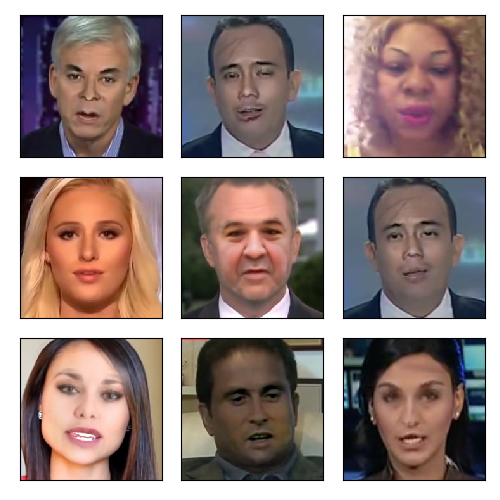

<IPython.core.display.Javascript object>


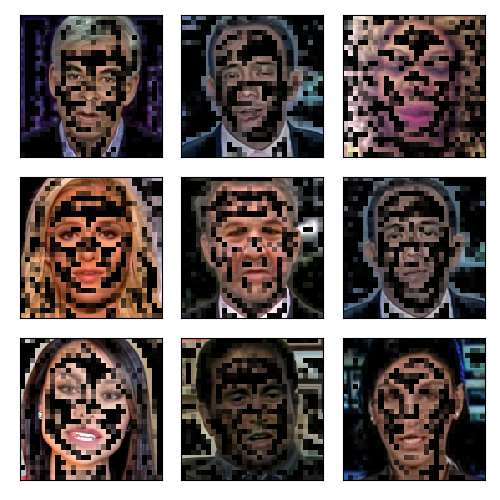

In [8]:
%matplotlib notebook

fig_im,axis_im = plt.subplots(3,3,figsize=(5,5))
fig_att,axis_att = plt.subplots(3,3,figsize=(5,5))
axis_im = axis_im.reshape(-1)
axis_att = axis_att.reshape(-1)

np.random.seed(41)
records = df.loc[np.random.choice(df.index,len(axis_im),replace=False)]

for idx,(ax_im,ax_att) in enumerate(zip(axis_im,axis_att)):
    record = records.iloc[idx]
    frame_im = Image.open(root.joinpath(record.name))
    bb = record['left'], record['top'], record['right'], record['bottom']
    face_im = utils.extract_bb(frame_im, bb=bb, size=face_size, scale=face_policy)
    face_t = data.load_face(record=record,
                          root=root,
                          size=face_size,
                          scale=face_policy,
                          transformer=transformer)
    with torch.no_grad():
        if hasattr(net,'feat_ext'):
            att = net.feat_ext.get_attention(face_t.unsqueeze(0))[0].cpu()
        else:
            att = net.get_attention(face_t.unsqueeze(0))[0].cpu()
    att_img = ToPILImage()(att)
    att_img = att_img.resize(face_im.size, resample=Image.NEAREST).convert('RGB')
    face_att_img = ImageChops.multiply(face_im, att_img)
    ax_im.imshow(face_im)
    ax_im.set_xticks([])
    ax_im.set_yticks([])
    ax_att.imshow(face_att_img)
    ax_att.set_xticks([])
    ax_att.set_yticks([])

fig_im.tight_layout()
fig_att.tight_layout()

# Feature vectors

In [28]:
num_videos = 20

np.random.seed(41)
real_videos = np.random.choice(df[df['label']==False]['video'].unique(),num_videos//2,replace=False)
fake_videos = np.random.choice(df[df['label']==True]['video'].unique(),num_videos//2,replace=False)
videos = np.concatenate((real_videos,fake_videos))

records = df.loc[df['video'].isin(videos)]

feat_list = []
for _,record in tqdm(records.iterrows(),total=len(records)):
    face_t = data.load_face(record=record,
                          root=root,
                          size=face_size,
                          scale=face_policy,
                          transformer=transformer)
    with torch.no_grad():
        feat = net.features(face_t.unsqueeze(0))
    feat_list.append(feat)

In [29]:
tsne = sklearn.manifold.TSNE(n_components=2,random_state=41)
tsne_feat = tsne.fit_transform(np.concatenate(feat_list))

<IPython.core.display.Javascript object>


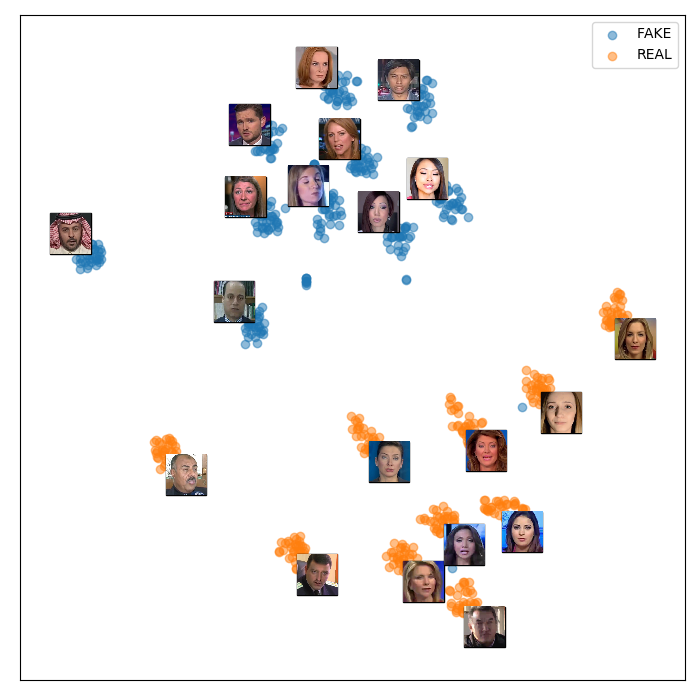

In [89]:
%matplotlib notebook

fig,ax = plt.subplots(1,1,figsize=(7,7))

for video in videos:
    record = records.loc[records['video'] == video].iloc[0]
    frame_im = Image.open(root.joinpath(record.name))
    bb = record['left'], record['top'], record['right'], record['bottom']
    face_im = utils.extract_bb(frame_im, bb=bb, size=face_size, scale=face_policy)
    
    img_ctr = np.median(tsne_feat[records['video'] == video],axis=0)
    
    imagebox = offsetbox.AnnotationBbox(
        offsetbox.OffsetImage(
            face_im,zoom=0.13,resample=True
        ),
        xy=img_ctr+((-3,3) if not record['label'] else (3,-3)),
        pad=0
    )
    ax.add_artist(imagebox)

ax.scatter(tsne_feat[records['label']==False,0],tsne_feat[records['label']==False,1],label='FAKE',alpha=0.5)
ax.scatter(tsne_feat[records['label']==True,0],tsne_feat[records['label']==True,1],label='REAL',alpha=0.5)
ax.set_xticks([])
ax.set_yticks([])
ax.set_ylim(ax.get_ylim()[0]-4,ax.get_ylim()[1]+4)
ax.set_xlim(ax.get_xlim()[0]-4,ax.get_xlim()[1]+4)

ax.legend()
fig.tight_layout()
fig.savefig('tsne_projection.pdf')